# Searching for New Passengers

On average, one third of taxi and TNC vehicles in Manhattan are empty during peak times.

*Empty Seats, Full Streets: Fixing Manhattan’s Traffic Problem* (Bruce Schaller)

http://schallerconsult.com/rideservices/emptyseats.htm

https://nyc.streetsblog.org/2017/12/21/schaller-curbing-uber-idle-time-key-to-busting-manhattan-gridlock/

Say we're a taxi driver working in a city in which the streets and intersections form, respectively, the vertices and edges of a graph with adjacency matrix A. We've taken careful note of the probability with which we can get a passenger on each street, and we'd like to use this information to limit the amount of time we have to spend driving around to find our next passenger. Where should we drive to minimize this waiting time?

In [1]:
import Pkg, GraphPlot
using DelimitedFiles, Colors, Compose
Pkg.activate("TaxiSearch")
using Setfield, Revise
using MAT, TaxiSearch

┌ Info: Recompiling stale cache file /home/sam/.julia/compiled/v1.0/TaxiSearch/uIxkm.ji for TaxiSearch [b90393e4-a556-11e8-02ce-05c8994ea979]
└ @ Base loading.jl:1184
┌ Warning: No working GUI backend found for matplotlib
└ @ PyPlot ~/.julia/packages/PyPlot/fZuOQ/src/init.jl:160


In [56]:
dbgNet = TaxiSearch.RoadNet(4);

# The graphs

## Grid graph

In [3]:
testNet = RoadNet(10);

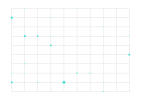

In [3]:
plotG(testNet)

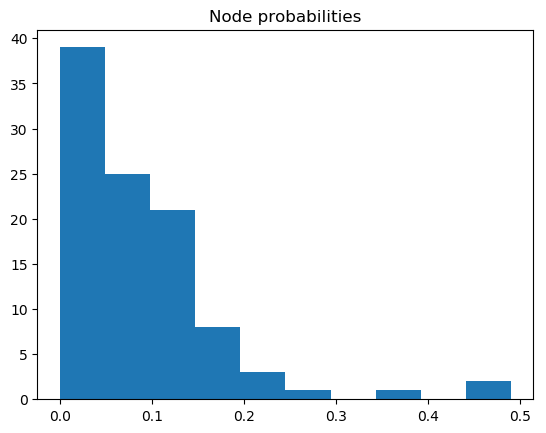

In [8]:
plt[:hist](testNet.lam); plt[:title]("Node probabilities");

## Train station

In [40]:
station = LG.Grid([6,6])
LG.add_vertices!(station, 5)
for i in 36:41
  LG.add_edge!(station, i, i+1)
end
station_lam = [fill(0.1, 36); fill(0.001, 5)]
station_lam[1] = 0.5
station_lam[19] = 0.3
stationM = ones(41,41)
stationM -= sparse(Diagonal(diag(stationM)));
stationM[1:36,37:41] .= 0
stationM[37:41,1:36] .= 0
stationM[1,:] .= 0
stationM[1,37] = 1
stationM[:, 1] .= 0
stationM ./= sum(stationM, dims=2);

In [41]:
station_demo = zeros(41,41)
station_demo[1,37] = 1;

In [47]:
stationX, stationY = GraphPlot.spring_layout(station);

In [49]:
stationNet = RoadNet(copy(LG.adjacency_matrix(station, Float64)'), station, stationM, nothing, station_lam, stationX, stationY);

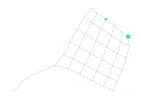

In [50]:
plotG(stationNet)

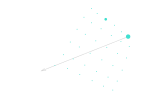

In [52]:
GraphPlot.gplot(LG.DiGraph(station_demo), stationX, stationY, arrowlengthfrac=0.08, edgelinewidth=0.001, nodesize=stationNet.lam)

## Manhattan

In [84]:
manhattan = getGraph("manhattan.csv");

In [91]:
manhattan_coords = readdlm("manhattan-coords.csv", ',', Float32);

In [ ]:
kevin = matread("kevin-data.mat");

In [126]:
manNet = RoadNet(manhattan, kevin["eveM"], nothing, kevin["eveP"][:,1], manhattan_coords[:,1], manhattan_coords[:,2]);

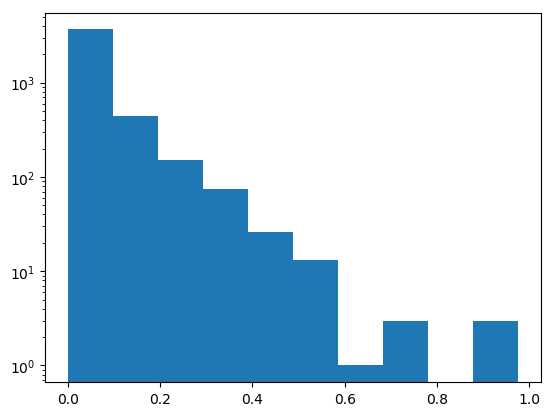

In [276]:
plt[:hist](manNet.lam, log=true);

# One taxi

## Expected waiting time

Let's assume that the probability of getting a passenger on any given street i within one time-step follows a Bernoulli distribution with probability of success $\lambda_i$.  Let the random variable $X_i$ indicate the number of time-steps it takes for a taxi to find the next passenger starting on street $i$. . Let the indicator random variable $P_i$ be $1$ if our taxi picks up a passenger at street $i$ within one time-step. If all streets take $1$ time-step to traverse and we continue driving until we find a passenger, $X_i = P_i + (1 - P_i)(1 + \min_{j \in N_o(i)}X_j)$, where $N(i)$ givs the outgoing neighbors of street $i$. The expected waiting time $x_i$ for a taxi on street $i$ is given therefore by the fixed point of the following equation:

$$
\label{greedEq}
x_i = \lambda_i+(1-\lambda_i)\left(1+\min_{j\in N(i)}x_j\right)
$$


In the min-plus (tropical) semiring in which the additive group operation is the minimum and the multiplicative group operation is addition, this is written as

$$
x= \lambda+ (1-\lambda)\circ (A \otimes x)
$$

In [4]:
function a1Min(A, lam)
  vals = fixedPoint(x->lam .+ (1 .- lam) .* (1 .+ neighborMin(A, x)[1]), 1 ./ lam)
  ptrs = neighborMin(A, vals)[2]
  pol = ptrPolicy(ptrs)
  (pol, vals, ptrs)
end

a1Min (generic function with 1 method)

Expected node wait times

In [5]:
testA1Min, testA1MinVals, testA1MinPtrs = a1Min(testNet.g, testNet.lam);

Converged in 44 steps


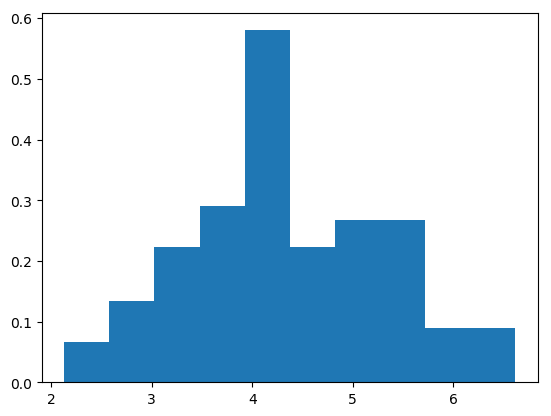

In [66]:
plt[:hist](testA1MinVals, density=true);

Empirical results:

min pol 1 stat 1 => 4.329208740130849


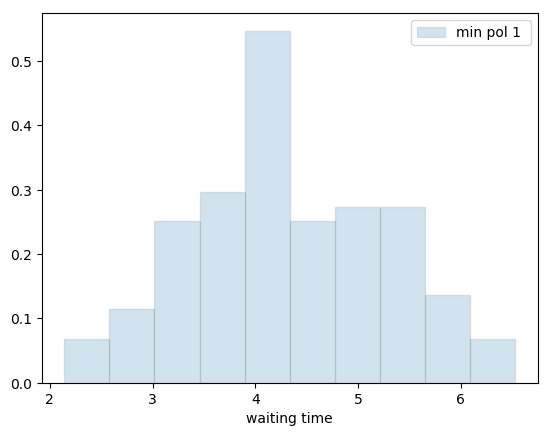

In [78]:
bench(oneEach(indivB), testNet, S([nodeWaitTimes],[]), P([:hist],[]), F([mean],[]), 50000; min=testA1Min)

In [79]:
realWaits = indivB(collect(1:length(testNet.lam)), testNet, S([nodeWaitTimes],[]), testA1Min, 50000).pol[1][1][2];

In [80]:
realWaitMean = collect(map(mean,realWaits));

Residuals

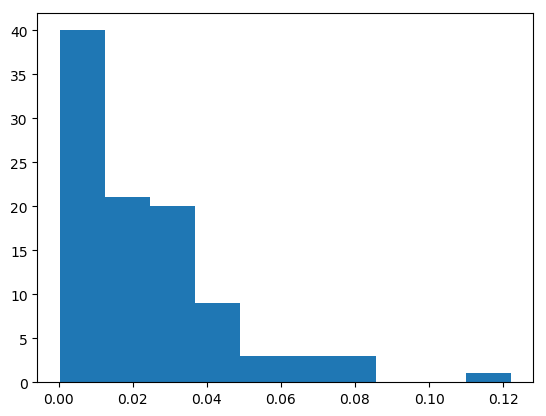

R^2 0.998891023405317


In [274]:
plt[:hist](abs.(realWaitMean - testA1MinVals));
println("R^2 ", 1 - sum((realWaitMean .- testA1MinVals).^2) / sum((realWaitMean .- mean(realWaitMean)).^2));

If the probability of a taxi getting a passenger is independent of the actions of other taxis, then the values $x_i$ are not only useful to an individual taxi driver, but to a taxi fleet operator as well. They will want to minimize the total waiting time of all the taxis in their fleet. The expected total waiting time is just the sum of the individual expected waiting times for each taxi, which are minimized by the equation above. 

Manhattan results

In [127]:
eve_pol, eve_vals, eve_ptrs = a1Min(manNet.g, manNet.lam);

Converged in 151 steps


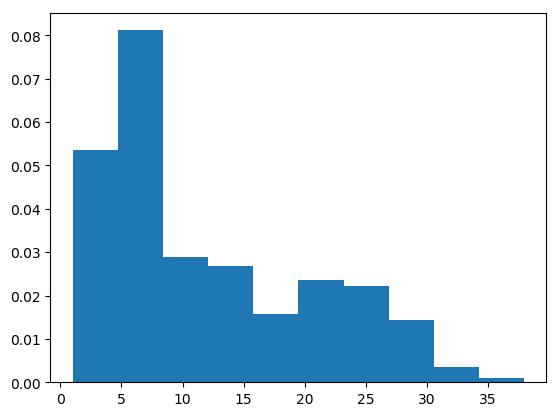

In [128]:
plt[:hist](eve_vals, density=true);

Results from simulation

min pol 1 stat 1 => 12.044720113184114


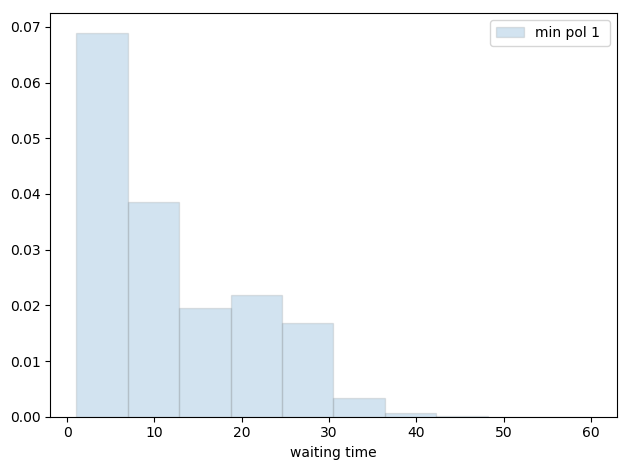

In [132]:
bench(oneEach(indivB), manNet, S([nodeWaitTimes],[]), P([:hist],[]), F([mean],[]), 30000; min=eve_pol)

## Comparison with baseline policies

rand pol 1 stat 1 0.6444887500000002 of 800
trained pol 1 stat 1 0.44990499999999983 of 800
greedy pol 1 stat 1 0.5046737499999999 of 800


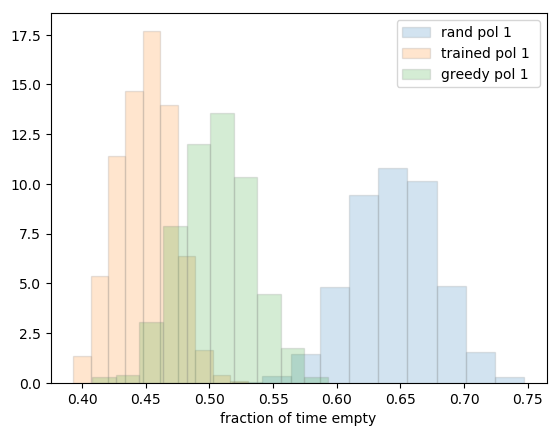

In [12]:
bench(withNTaxis(800, indivB), testNet, S([taxiEmptyFrac],[]), P([:hist],[]), F([id],[]);
  rand=randPol(testNet), trained=testA1Min, greedy=greedyPol(testNet))

But we're not just doing the easy thing of going to the global max

In [13]:
testH = hotPtrs(testNet);

hot pol 1 stat 1 0.5016900000000001 of 1000
rnd pol 1 stat 1 0.644071 of 1000
trained pol 1 stat 1 0.4506269999999997 of 1000
greedy pol 1 stat 1 0.5044029999999999 of 1000


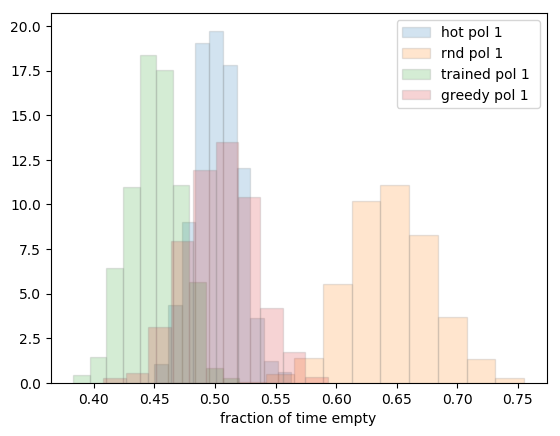

In [14]:
bench(withNTaxis(1000, indivB), testNet, S([taxiEmptyFrac],[]), P([:hist],[]), F([id],[]);
  hot=ptrPolicy(testH), rnd=randPol(testNet), trained=testA1Min, greedy=greedyPol(testNet))

In [15]:
routeDiff(testH, testA1MinPtrs)

0.51

We can also compare the mean wait time means for each node

rand pol 1 stat 1 => 9.842878300621301
trained pol 1 stat 1 => 4.306234199860052
greedy pol 1 stat 1 => 5.473075798990315


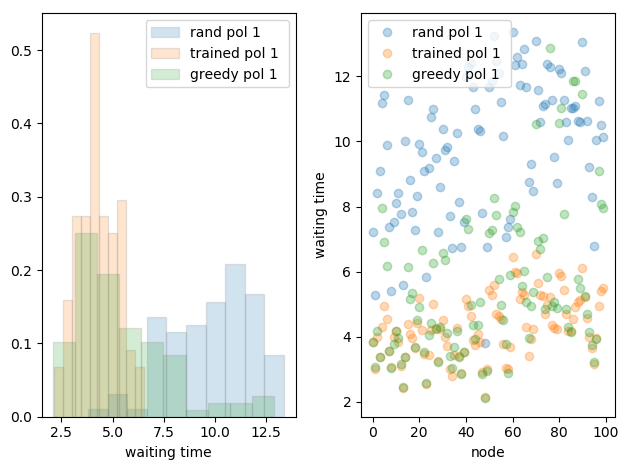

In [130]:
bench(withNTaxis(1000,indivB), testNet, S([nodeWaitTimes], []), P([:hist; :scatter],[]), F([mean],[]);
  rand=randPol(testNet), trained=testA1Min, greedy=greedyPol(testNet))

Or their standard deviations

rand pol 1 stat 1 => 9.286406636278175
trained pol 1 stat 1 => 2.506120042023783
greedy pol 1 stat 1 => 4.240437478182393


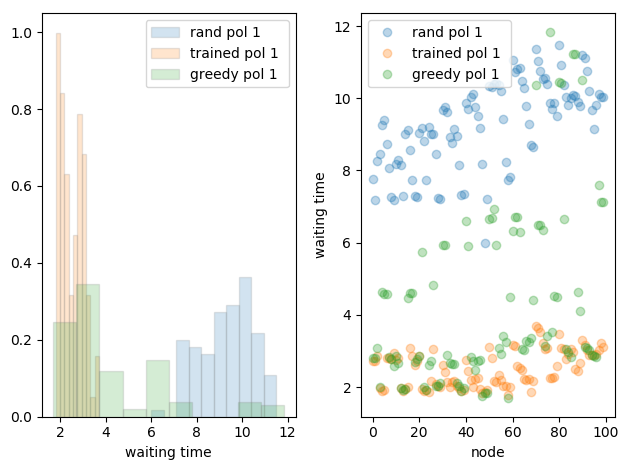

In [131]:
bench(withNTaxis(1000,indivB), testNet, S([nodeWaitTimes], []), P([:hist; :scatter], []), F([std],[]);
  rand=randPol(testNet), trained=testA1Min, greedy=greedyPol(testNet))

Results in Manhattan

trained pol 1 stat 1 => 0.26960999999999996
rand pol 1 stat 1 => 0.7375486666666667
greedy pol 1 stat 1 => 0.6462953333333332


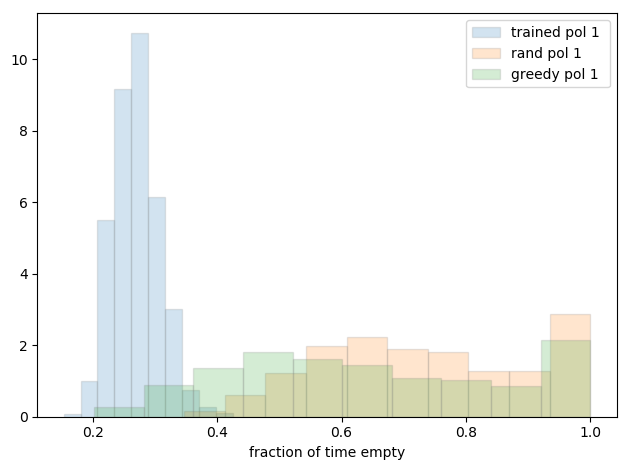

In [134]:
bench(withNTaxis(1500, indivB), manNet, S([taxiEmptyFrac],[]), P([:hist],[]), F([id],[]);
  trained=eve_pol, rand=randPol(manNet), greedy=greedyPol(manNet))

## Tracing the routes

In [19]:
testA1MinG = LG.DiGraph(testA1Min');

Grid graph routes

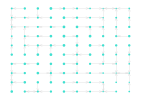

In [20]:
plotG(testA1MinG, testNet, testA1MinVals)

These routes settle into a small number of hot spots

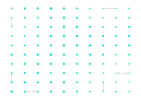

In [21]:
plotG(justCycles(testA1MinG), testNet, testA1MinVals)

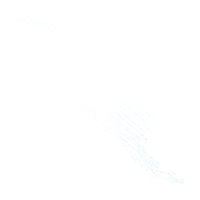

In [146]:
plotG(justCycles(eve_pol), manNet, eve_vals, nodefillc=colorant"lightblue", edgestrokec=colorant"black",
  arrowlengthfrac=0.004) |> SVG(20cm,20cm)

## Changes in entropy 

In [52]:
function gap(f, net)
  order = randperm(size(net.g)[1])
  entropies = Float64[]
  ratios = Float64[]
  for p in -(0.11:0.1:1.2)
    netP = @set net.lam = mkP(order .^ p, 2)
    fP = f(netP)
    push!(entropies, entropy(toDist(netP.lam)))
    push!(ratios, mean(withNTaxis(1000,indivB)(netP, TaxiEmptyFrac, a1Min(netP.g, netP.lam)[1]).pol[1][1]) /
      mean(withNTaxis(1000,indivB)(netP, TaxiEmptyFrac, fP).pol[1][1]))
  end
  plot(entropies, ratios, xlabel="entropy", ylabel="ratio", legend=false)
end

gap (generic function with 1 method)

Converged in 23 steps
Converged in 33 steps
Converged in 42 steps
Converged in 53 steps
Converged in 65 steps
Converged in 79 steps
Converged in 93 steps
Converged in 110 steps
Converged in 128 steps
Converged in 147 steps
Converged in 169 steps


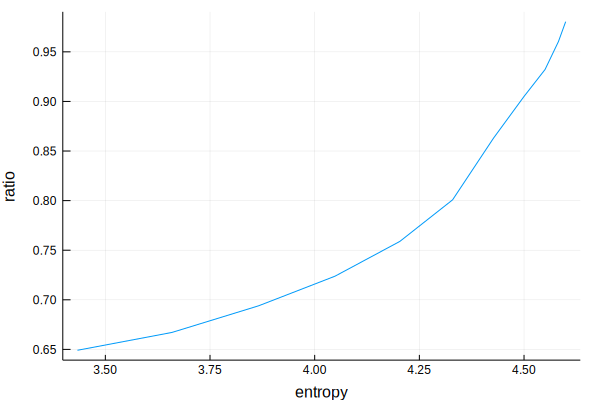

In [53]:
gap(greedyPol, testNet)

## Scaling probabilities

Assume passengers hang around for $\delta$ time-steps after generation

If there is no compeition among drivers, this is equivalent to increasing the probabilities at each node by a factor of $\delta$. Interestingly, increasing the probabilities by a constant factor changes the optimal route by over 25%!

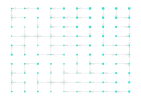

In [161]:
plotG(testA1Min, testNet, testA1MinVals)

Converged in 36 steps
Route fraction changed: 0.21


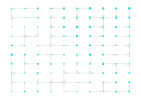

In [162]:
testA1Min2, testA1MinVals2, testA1MinPtrs2 = a1Min(testNet.g, testNet.lam .* 3)
println("Route fraction changed: ", norm(testA1MinPtrs - testA1MinPtrs2, 0) / length(testA1MinPtrs))
plotG(testA1Min2, testNet, testA1MinVals2)

This also makes them settle into different cycles

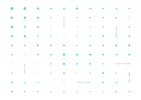

In [9]:
plotG(justCycles(testA1Min2), testNet, testA1MinVals2)

In [180]:
function inflationGap(A, lam)
  xs = collect(1.1:0.2:3.5)
  orig = a1Min(A, lam)[3]
  plt[:plot](xs, [norm(orig - a1Min(A, lam .* n)[3], 0) ./ length(orig) for n in xs]);
end

inflationGap (generic function with 1 method)

Route fraction changed by constant multiplier

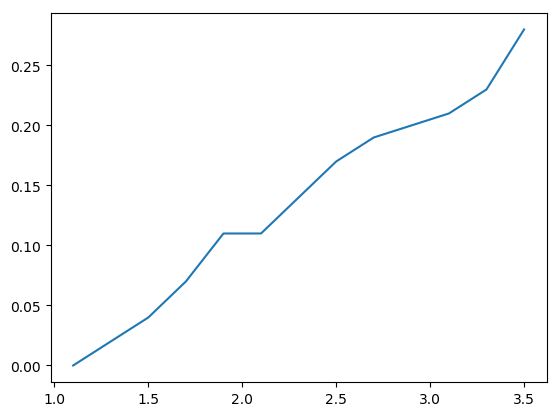

In [182]:
redirect_stdout(open("/dev/null", "w")) do
  inflationGap(testNet.g, testNet.lam)
end;

## Dealing with variance

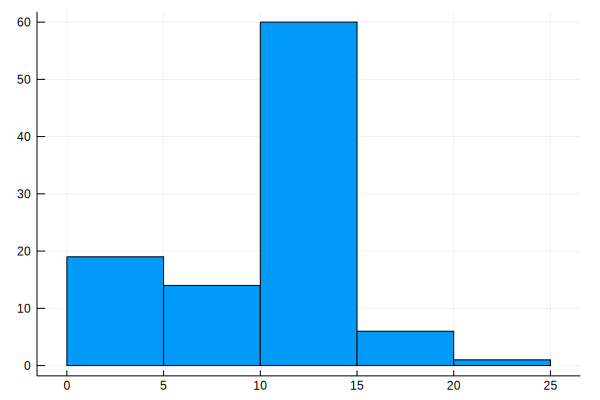

In [33]:
histogram(var.(realWaits), legend=false)

$\newcommand{\E}{\mathrm{E}}$
$\newcommand{\Var}{\mathrm{Var}}$
$\newcommand{\Cov}{\mathrm{Cov}}$

Let $y = \E[X^2]$ be the expected squared waiting time. Then
$$
y_i = \lambda_i + (1-\lambda_i)(1 + y^* + 2\sqrt{y^*}) \text{ where } y^* = \min_{j \in N(i)} y_j
$$

The variance is given by $\Var[X] = y - x^2$. 

In [35]:
function a1MinSq(net)
  fixedPoint(y-> begin
    yStar = neighborMin(net.g, y)[1]
    net.lam .+ (1 .- net.lam) .* (1 .+ yStar .+ 2 .* sqrt.(yStar))
    end, 1 ./ net.lam)
end

a1MinSq (generic function with 2 methods)

In [36]:
testA1MinVar = a1MinSq(testNet) .- testA1MinVals.^2;

Converged in 100 steps


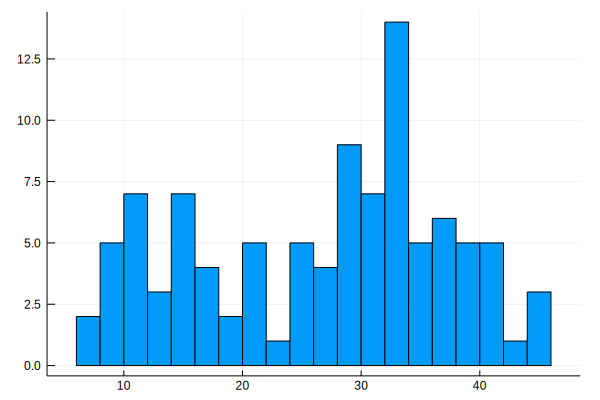

In [37]:
histogram(testA1MinVar, nbins=25, legend=false)

Residuals from our prediction:

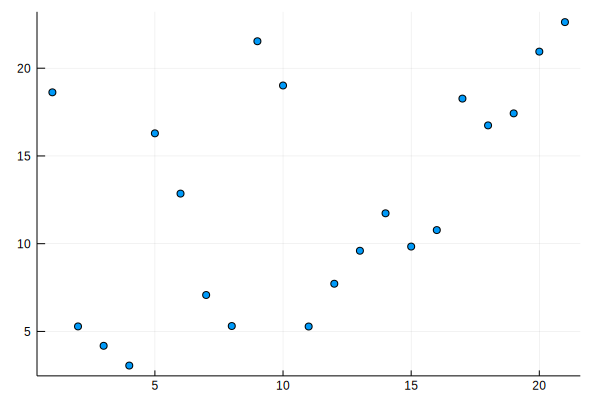

In [38]:
scatter(nonNan(abs.(map(x->length(x) > 2000 ? var(x) : NaN, realWaits) - testA1MinVar)), legend=false)

## Conservative policies

In [21]:
testA1MinCons = greedyPol(testNet, testA1MinVals .+ sqrt.(testA1MinVar));

LoadError: UndefVarError: testA1MinVar not defined

In [42]:
testA1MinCons2 = greedyPol(testNet, testA1MinVals .+ std.(realWaits));

expected 0.43085999999999997
conservative1 0.7466349999999999
conservative2 0.73346


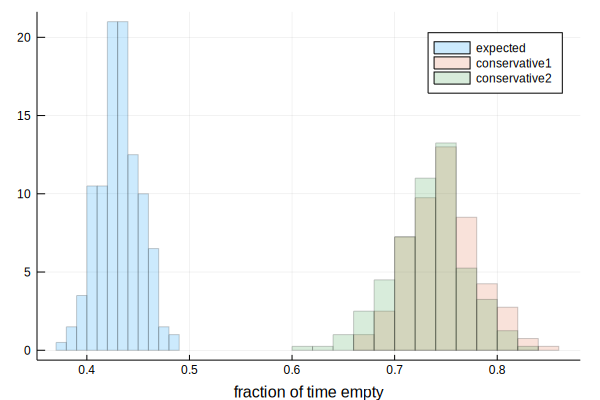

In [49]:
bench(withNTaxis(200, indivB), id, :hist, testNet, TaxiEmptyFrac; expected=testA1Min, conservative1=testA1MinCons, conservative2=testA1MinCons2)

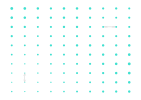

In [56]:
theTime =  testA1MinVals .+ sqrt.(testA1MinVar)
plotG(justCycles(ptrPolicy(neighborMin(testNet.g,theTime)[2])), testNet, theTime)

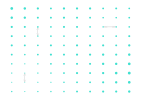

In [60]:
plotG(justCycles(testA1Min), testNet, testA1MinVals)

## Using rates, not probabilities

The lambdas can be rates of passenger pickup, not probabilities. That way we move to variable length streets without the icky equation. The waiting time will come from an exponential distribution. We need to know the probability that the exponential variable is greater than some amount (the street length). That's 1 - the cdf of the exponential ($1 - e^{\lambda x}$). This new form is therefore:

$$ x_i = (1 - e^{-\lambda_i L_i})(\lambda_i^{-1} - l(e^{\lambda_i L_i} - 1)^{-1}) + e^{-\lambda_i L_i}\left( L_i + \min_{j \in N(i)} x_j \right)$$

See
https://www.quora.com/Does-the-truncated-exponential-distribution-have-an-expected-value, http://thescipub.com/PDF/jmssp.2008.284.288.pdf

In [41]:
truncExpMu(lam, l) = (1 ./ lam) - l ./ (exp.(lam .* l) .- 1)

truncExpMu (generic function with 1 method)

In [60]:
function a1RMin(A, lam, len)
  p = exp.(-lam .* len)
  gotPass = truncExpMu(lam, len) .* (1 .- p)
  vals = fixedPoint(x-> gotPass .+ p .* (len .+ neighborMin(A, x)[1]), 1 ./ lam)
  ptrs = neighborMin(A, vals)[2]
  pol = ptrPolicy(ptrs)
  (pol, vals, ptrs)
end

a1RMin (generic function with 1 method)

In [61]:
wSize = @set testNet.len = ones(length(testNet.lam));
wSize = @set wSize.lam = toContinuous.(wSize.lam);

In [62]:
testRMin, testRVals, testRPtrs = a1RMin(wSize.g, wSize.lam, wSize.lam);

Converged in 66 steps


In [46]:
routeDiff(testRPtrs, testA1MinPtrs)

0.78

bernoulli pol 1 stat 1 => 0.3650368934640841
exp pol 1 stat 1 => 0.49810073839022456


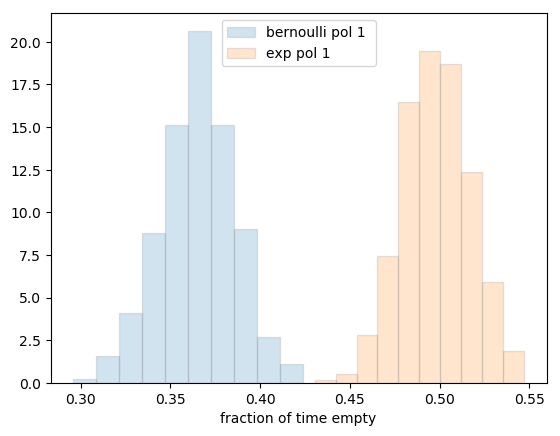

In [51]:
bench(withNTaxis(1000,indivE), wSize, S([taxiEmptyFrac],[]), P([:hist],[]), F([id],[]);
  bernoulli=testA1Min, exp=testRMin)

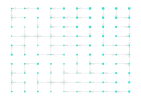

In [56]:
plotG(testA1Min, testNet, testA1MinVals)

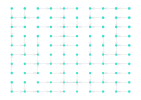

In [54]:
plotG(testRMin, testNet, testRVaks)

In [56]:
testLNet = changeLen(testNet, abs.(randn(length(testNet.lam)) .* 0.3 .+ 1))
testLNet = @set testLNet.lam = toContinuous.(testLNet.lam);

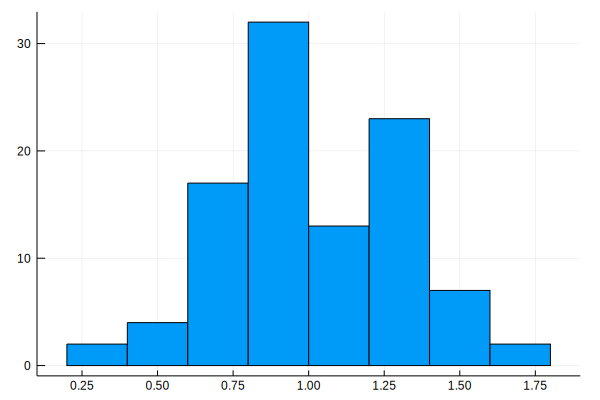

In [53]:
histogram(testLNet.len, legend=false)

In [57]:
testRate, testRateVals, testRatePtrs = a1RMin(testLNet.g, testLNet.lam, testLNet.len);

Converged in 69 steps


bernoulli 0.8329933329702918
exp 0.48540863546729096
rand 0.6933209186341301


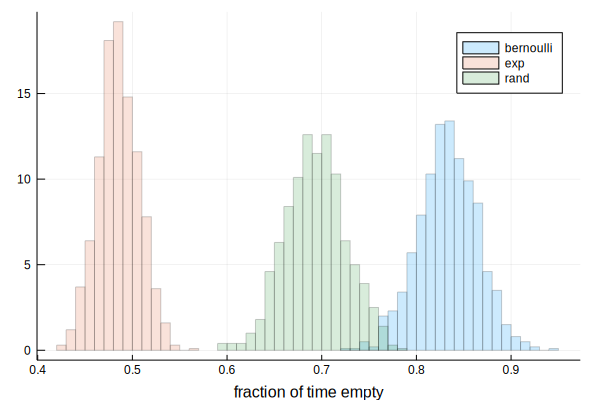

In [63]:
bench(withNTaxis(1000,indivE), id, :hist, testLNet, TaxiEmptyFrac;
  bernoulli=testA1Min, exp=testRate, rand=randPol(testLNet))

In [67]:
function expGap(net0, bernMin)
  order = randperm(size(net0.g)[1])
  entropies = Float64[]
  ratios = Float64[]
  for p in -(0.01:0.5:2.5)
    len = mkP(order .^ p, 0.1)
    push!(entropies, entropy(toDist(len)))
    net = changeLen(net0, len)
    push!(ratios, 
      mean(withNTaxis(800, indivE)(net, TaxiEmptyFrac, uni(a1RMin(net.g, net.lam, net.len)[1])).pol[1][1]) /
      mean(withNTaxis(800, indivE)(net, TaxiEmptyFrac, bernMin).pol[1][1]))
  end
  plot(entropies, ratios, xlabel="entropy", ylabel="ratio with bernoulli", legend=false)
end

expGap (generic function with 1 method)

Converged in 13 steps
Converged in 51 steps
Converged in 178 steps
Converged in 1201 steps
Converged in 5733 steps


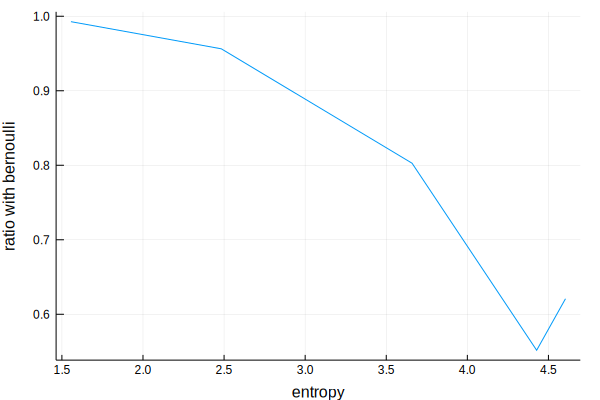

In [68]:
expGap(testLNet, uni(testA1Min))

# Multiple trips

## N-trip waiting time

There are situations in which minimizing the waiting time before trip $t$ can end up increasing your waiting time before trip $t+1$. Outside a train station, for example, the probability of finding a passenger is quite high. But potential passengers outside a train station are likely to want to go into residential areas where a taxi is far less likely to get hailed. On reflection, it seems we are not interested in minimizing the waiting time before the next trip so much as minimizing the sum of all waiting time over the course of a sufficiently long period. This requires knowledge of passengers' trip probabilities. Let $M_{ij}$ be the probability a passenger who hails a ride at street $i$ is going to street $j$. Let $x_i^n$ be the expected total waiting time over $n$ trips starting from street $i$. Assume unit length streets for simplicity. 

$$
\label{unitMulti}
x^0 = 0 \\
x^n = P(1 + M^Tx^{n-1}) + Q(A \otimes x^n)
$$

With a proportional policy, this is 
$$
x^0 = 0 \\
x^n = P(1 + M^Tx^{n-1}) + Q(1 + \Pi_{x_n}^T x^n)
$$

In [266]:
# Proportional dispatch
function a1T2Prop(A, lam, M; ahead=3)
  vals = iterated(oldX-> fixedPoint(x-> lam .* (1 .+ M * oldX) .+ (1 .- lam) .* (1 .+ scorePolicy(1 ./ x, A)' * x),
      oldX .+ 1 ./ lam), ahead, zeros(length(lam)))
  (scorePolicy(1 ./ vals, A), vals)
end

# Greedy dispatch
function a1T2Min(A, lam, M; ahead=3)
  vals = iterated(oldX-> fixedPoint(x-> lam .* (1 .+ M * oldX) .+ (1 .- lam) .* (1 .+ neighborMin(A, x)[1]),
      oldX .+ 1 ./ lam), ahead, zeros(length(lam)))
  ptrs = neighborMin(A, vals)[2]
  pol = ptrPolicy(ptrs)
  (pol, vals, ptrs)
end

a1T2Min (generic function with 1 method)

## Single trip comparison

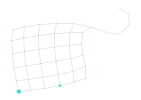

In [200]:
plotG(stationNet)

In [246]:
stationPol, stationVals, stationPtrs = a1Min(stationNet.g, stationNet.lam);

Converged in 43 steps


The one-trip equation naively gives the corner intersection a low expected wait time:

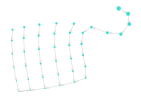

In [256]:
plotG(stationPol, stationNet, stationVals)

The ideal route, supposedly, ends up hanging around this corner intersection, waiting for a ride that will take it into an unpopular part of town.

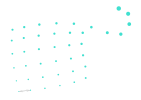

In [248]:
plotG(justCycles(stationPol), stationNet, stationVals)

If we look at the expected waiting time for the second trip, it's clear that this can be counterproductive:

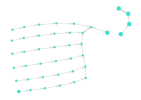

In [262]:
next_vals = stationNet.M * stationVals
next_pol = ptrPolicy(neighborMin(stationNet.g, next_vals)[2])
plotG(next_pol, stationNet, next_vals)

The multi-trip formulation accounts for this:

Iteration 1
Converged in 43 steps
Iteration 2
Converged in 64 steps


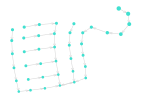

In [269]:
station_pol2, station_vals2, station_ptrs2 = a1T2Min(stationNet.g, stationNet.lam, stationNet.M; ahead=2);
plotG(station_pol2, stationNet, nodesize=station_vals2)

The basin of attraction is now safely away from the corner intersection.

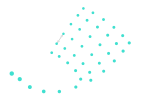

In [101]:
gplot(justCycles(station_g2), stationX, stationY, arrowlengthfrac=0.06, nodesize=station_vals2)

In [271]:
norm(stationPtrs - station_ptrs2, 0) / length(stationPtrs)

0.3170731707317073

Simulated waiting times

single 0.8161649484536083
multi 0.6172061855670101


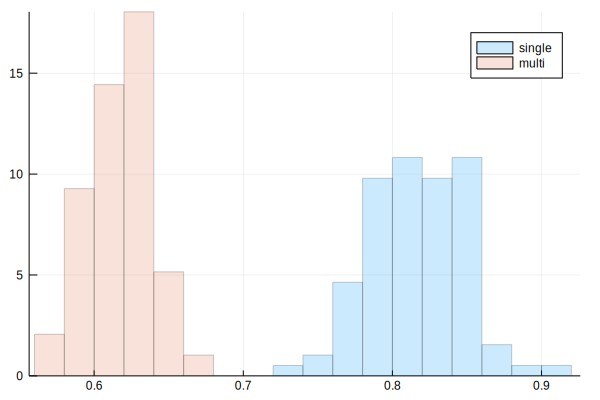

In [50]:
compareFor(indep(station_lam), station_M, station_dists, 3; single=constant(station_pol), multi=constant(station_pol2))

## Entropy comparison

We don't expect to see any real difference when $M$ has no structure, however. 

In [115]:
testA1T2Min, _, testA1T2MinPtrs = a1T2Min(testA, testLam, testM; ahead=20);

Iteration 1
Converged in 73 steps
Iteration 2
Converged in 68 steps
Iteration 3
Converged in 67 steps
Iteration 4
Converged in 66 steps
Iteration 5
Converged in 65 steps
Iteration 6
Converged in 64 steps
Iteration 7
Converged in 63 steps
Iteration 8
Converged in 63 steps
Iteration 9
Converged in 62 steps
Iteration 10
Converged in 62 steps
Iteration 11
Converged in 61 steps
Iteration 12
Converged in 61 steps
Iteration 13
Converged in 61 steps
Iteration 14
Converged in 60 steps
Iteration 15
Converged in 60 steps
Iteration 16
Converged in 60 steps
Iteration 17
Converged in 60 steps
Iteration 18
Converged in 59 steps
Iteration 19
Converged in 59 steps
Iteration 20
Converged in 59 steps


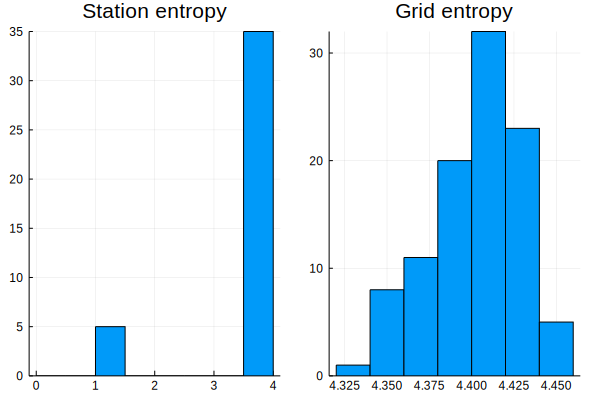

In [29]:
Plots.plot(
  histogram([@views StatsBase.entropy(station_M[i, :]) for i in 1:length(station_lam)], legend=false, title="Station entropy"),
  histogram([@views StatsBase.entropy(testM[i, :]) for i in 1:testRoads], legend=false, title="Grid entropy"))
  

The grid environment, with mostly uniform transition probabilities, shows no improvement with the multi-trip formulation

In [116]:
norm(testA1T2MinPtrs - testA1MinPtrs, 0) / length(testA1MinPtrs)

0.01

single 0.43165957446808506
multi 0.4309414893617021


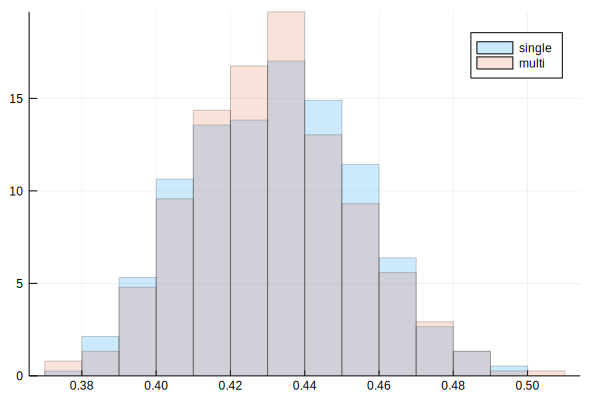

In [33]:
compareFor(indep(testLam), testM, testDists, 5; single=testA1Min, multi=testA1T2Min)

# Competing taxis

## Using single agent policies

rand pol 1 stat 1 => 0.6612
rand pol 1 stat 2 => 11.62765546613085
trained pol 1 stat 1 => 0.4657000000000001
trained pol 1 stat 2 => 6.113437431127344
greedy pol 1 stat 1 => 0.5326000000000001
greedy pol 1 stat 2 => 7.237410589289814


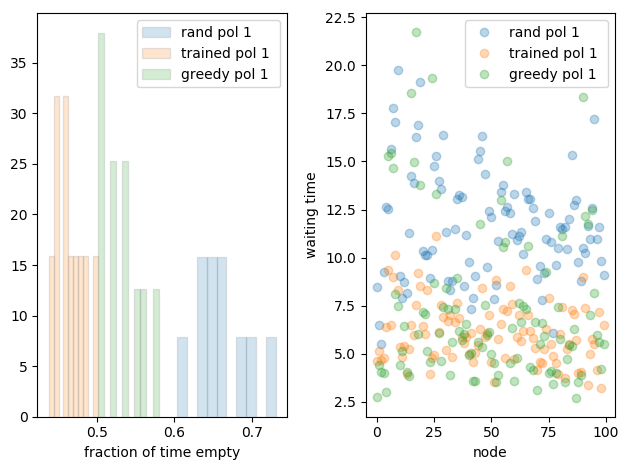

In [7]:
bench(withNTaxis(10,competP), testNet, S([taxiEmptyFrac, nodeWaitTimes], []), P([:hist, :scatter],[]), F([id, mean],[]);
  rand=randPol(testNet), trained=testA1Min, greedy=greedyPol(testNet))

Oops

rand pol 1 stat 1 => 0.857274
rand pol 1 stat 2 => 38.81131949889028
trained pol 1 stat 1 => 0.9640579999999996
trained pol 1 stat 2 => 122.59584812974734
greedy pol 1 stat 1 => 0.933576
greedy pol 1 stat 2 => 74.70708836996887


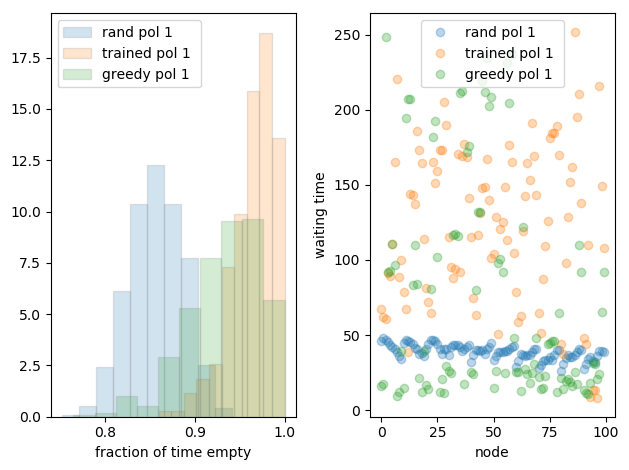

In [11]:
bench(withNTaxis(500,competP), testNet, S([taxiEmptyFrac, nodeWaitTimes], []), P([:hist, :scatter],[]), F([id, mean],[]);
  rand=randPol(testNet), trained=testA1Min, greedy=greedyPol(testNet))

The situation isn't good for passengers either

gbl rand 1 0.031003862714691934
gbl trained 1 0.8423415189515137
gbl greedy 1 0.7540935425719133


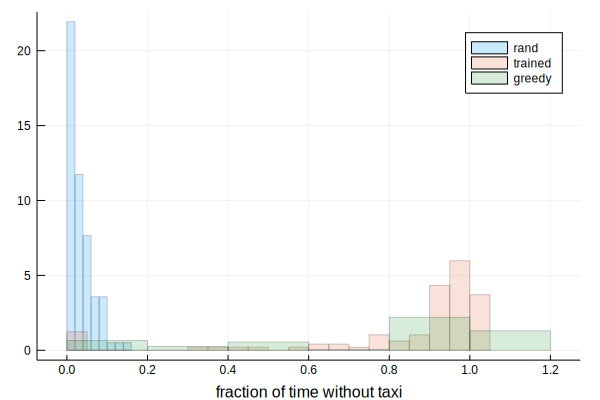

In [78]:
bench(withNTaxis(500, competB), :hist, testNet, NodeSOLFrac; rand=randPol(testNet), trained=testA1Min, greedy=greedyPol(testNet))

Individually optimal taxis all go to the same place

gbl rand 1 11.632
gbl trained 1 109.721
gbl greedy 1 68.495


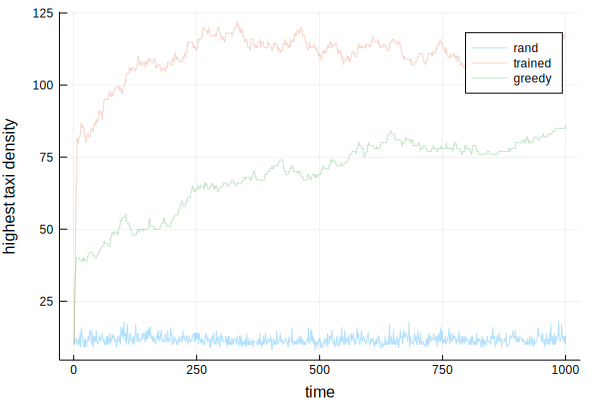

In [81]:
bench(withNTaxis(500, competB), :line, testNet, MaxCars; rand=randPol(testNet), trained=testA1Min, greedy=greedyPol(testNet))

In [149]:
meanEmptyFrac(n, net, p) = mean(withNTaxis(n, competP)(net, S([taxiEmptyFrac],[]), p).pol[1][1][2])

meanEmptyFrac (generic function with 1 method)

In [150]:
xs = 2:3:300

2:3:299

Mean empty time vs number of taxis

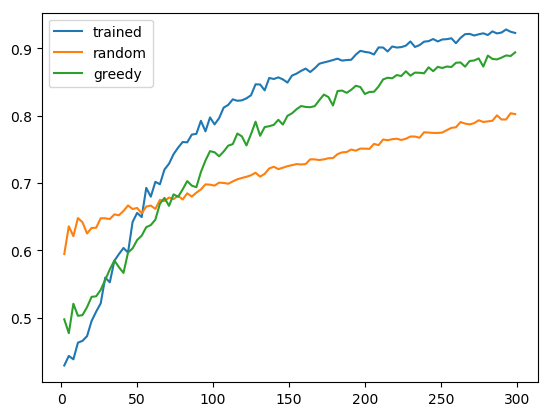

In [151]:
plt[:plot](xs, [meanEmptyFrac(i, testNet, testA1Min) for i in xs], label="trained")
plt[:plot](xs, [meanEmptyFrac(i, testNet, randPol(testNet)) for i in xs], label="random")
plt[:plot](xs, [meanEmptyFrac(i, testNet, greedyPol(testNet)) for i in xs], label="greedy")
plt[:legend]();

## Heterogeneous environment

In [152]:
smarty = solo(testA1Min, randPol(testNet));

Trained can still beat random if there's only one smart cab

mixed pol 1 stat 1 => 0.454
mixed pol 2 stat 1 => 0.6641224489795918


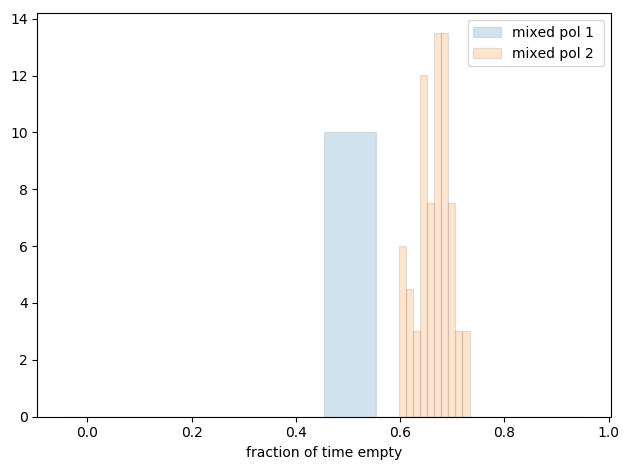

In [154]:
bench(withNTaxis(50, competP), testNet, S([taxiEmptyFrac], []), P([:hist],[]), F([id],[]); mixed=smarty)

In [158]:
function polGap(p, net, n)
  p1, p2 = withNTaxis(n, competP)(net, S([taxiEmptyFrac], []), p).pol
  mean(p1[1][2]) / mean(p2[1][2])
end

polGap (generic function with 1 method)

Ratio of empty times vs number of taxis

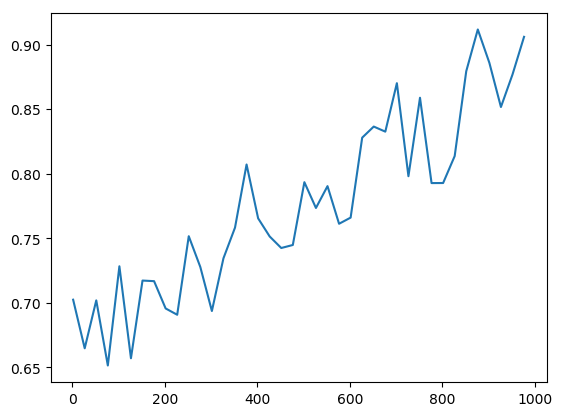

In [159]:
ns = 2:25:1000
plt[:plot](ns, [polGap(smarty, testNet, n) for n in ns]);

## Cooperative policy

$$
x(0) = 0 \\
x(\rho)= \rho \cdot 1 + x(\Pi(\rho - S_\rho))
$$

In [66]:
stDict = mcTabular(dbgNet)

(::getfield(TaxiSearch, Symbol("#predict#124")){DataStructures.DefaultDict{Array{Int64,1},Pair{Float64,Int64},Pair{Float64,Int64}}}) (generic function with 1 method)

In [67]:
myPol = PolFn((rho, l)->greedyAction(dbgNet, rho, stDict, l))

FunctionWrappers.FunctionWrapper{Int64,Tuple{Array{Int64,1},Int64}}(Ptr{Nothing} @0x00007f5f6a91cdf0, Ptr{Nothing} @0x00007f5f7ff28178, Base.RefValue{getfield(Main, Symbol("##15#16"))}(getfield(Main, Symbol("##15#16"))()), getfield(Main, Symbol("##15#16")))

rand pol 1 stat 1 => 0.81685
rand pol 1 stat 2 => 0.81685
greedy pol 1 stat 1 => 0.741775
greedy pol 1 stat 2 => 0.741775
mc pol 1 stat 1 => 0.785925
mc pol 1 stat 2 => 0.785925


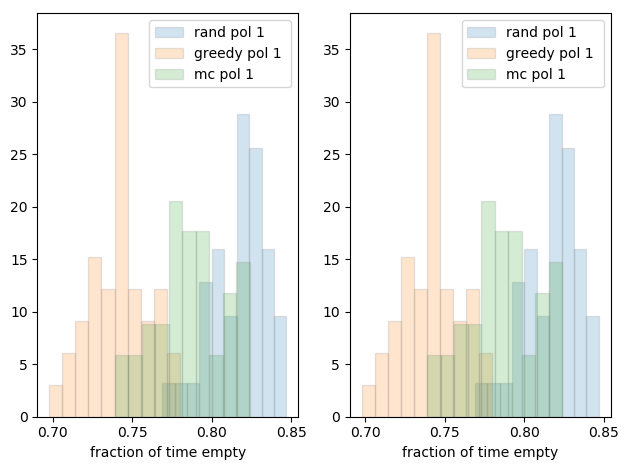

In [68]:
bench(withNTaxis(2,competP), dbgNet, S([taxiEmptyFrac], []), P([:hist],[]), F([id, mean],[]), 20;
  rand=randPol(dbgNet), greedy=greedyPol(dbgNet), mc=myPol)

## Competing with neural nets

A better solution is to bake competition into our model directly.

The vector of trip request rates is $\lambda$, and the vector of taxi densities (not including the taxi in consideration) is $\rho$. We assume that the probability a particular taxi gets a trip is $\left(\frac{\lambda}{\rho+1}\right)$. The number of passengers looking for a ride is Poisson with rate $\lambda$. The probability of an individual taxi getting the passenger (given one is generated) is just $1 - \prod_{i=0}^{\rho}\frac{\rho-i}{\rho-i+1}$. Everything cancels except $\rho/(\rho + 1)$.


Let $\Pi_\rho$ be the policy followed when densities are at $\rho$. Let $\rho'$ be the new densities after one timestep has passed. We don't know exactly what these new densities will be, but we can sample from a Poisson with rate $\lambda$ and subtract this from $\rho$, keeping everything about 0. Then the expected waiting time for a taxi introduced at a node $i$ is given by $x_i$ where

$$ x_\rho = \frac{\lambda}{\rho + 1} + \left(1 - \frac{\lambda}{\rho + 1}\right) (1 + \Pi_{\rho'}^Tx_{\rho'})$$

In [95]:
using Knet, VisdomLog

In [108]:
ModelTy = Tuple{Array{Float64,2}, Vec}

Tuple{Array{Float64,2},Array{Float64,1}}

In [97]:
predict(params, rho) = (params[1] * rho .+ params[2]).^2 .+ 1

predict (generic function with 1 method)

In [290]:
function minLoss(params, rho, A, lam, plam)
  timeEst = predict(params, rho)
  pol = ptrPolicy(neighborMin(A, getval(timeEst))[2])
  p = lam ./ (rho .+ 1)
  newRho = sampleNewRho(pol, plam, rho)
  newEst = getval(predict(params, newRho))
  unlucky = (1 .- p) .* (1 .+ neighborMin(A, newEst)[1])
  mean(abs2, (p .+ unlucky) - timeEst)
end

minLossFn = gradloss(minLoss);

In [282]:
function sampleNewRho(pol, plam, rho)
  found = rand.(plam)
  postFound = max.(0, rho - rand.(plam))
  pol * postFound
end

sampleNewRho (generic function with 1 method)

As before, the policy matrix $\Pi_\rho$ is just $1/x_\rho$ multiplied columnwise on the adjacency matrix and normalized

In [284]:
struct StopTraining <: Exception end

In [352]:
function keepTraining(A::Graph, lam::Vec, k::Int, model::ModelTy, lossF)
  plam = Poisson.(lam)
  roads = length(lam)
  visdom = Visdom("traceVals3", [:loss, :w, :b]);
  o = optimizers(model, Adam, lr=0.01);
  running_loss = 0.0
  i = 0
  try
    while true
      yield()
      i += 1
      rho = trunc.(min.(10.0, randexp(roads) .* k))
      g, l = lossF(model, rho, A, lam, plam)
      running_loss += l
      if i % 100 == 0
        report(visdom, :loss, [running_loss / 100.0])
        VisdomLog.inform(visdom, :w, model[1])
        VisdomLog.inform(visdom, :b, model[2])
        running_loss = 0.0
      end
      update!(model, g, o)
    end
  catch e
    if isa(e, StopTraining)
      return model
    end
    rethrow()
  end
end

keepTraining (generic function with 3 methods)

In [345]:
# Dang, we can't use KNet on sparse matrices. 
# Should we abandon Knet? Could just do backprop manually. Or use ReverseDiff.
function train(A::Graph, lam::Vec, k::Int, mask::Graph, loss)
  roads = length(lam)
#   w = SparseMatrixCSC(mask.m, mask.n, mask.colptr, mask.rowval,
#     0.01*rand(length(mask.nzval)))`
  w = sqrt.(abs.(randn(size(A))))
  b = sqrt.(1 ./ lam) .- 1
  keepTraining(A, lam, k, (w, b), loss)
end

train (generic function with 2 methods)

In [110]:
neighborhoods(g::Graph, n::Int)::Graph = (g + speye(g))^n .> 0

neighborhoods (generic function with 1 method)

But having each taxi follow the identical greedy policy does not converge. Whenever taxis find a better place to go, everyone goes there, and it no longer beomes a good place. A proportional policy works much better.

In [286]:
function propLoss(params, rho, A, lam, plam)
  timeEst = predict(params, rho)
  pol = scorePolicy(1 ./ getval(timeEst), A)
  p = lam ./ (rho .+ 1)
  newRho = sampleNewRho(pol, plam, rho)
  newEst = getval(predict(params, newRho))
  newPol = scorePolicy(1 ./ newEst, A)
  unlucky = (1 .- p) .* (1 .+ (newPol' * newEst))
  mean(abs2, p + unlucky - timeEst)
end

propLossFn = gradloss(propLoss);

In [350]:
t2 = @schedule train(testA, testLam, 2, neighborhoods(testA, 8), propLossFn)

Task (queued) @0x00007f568e5197b0

In [351]:
schedule(t2, StopTraining(), error=true);

LoadError: [91mschedule: Task not runnable[39m

In [298]:
testModel = fetch(t2);

In [299]:
testPol= rho->scorePolicy(1 ./ predict(testModel, rho), testA);

Trained parameters

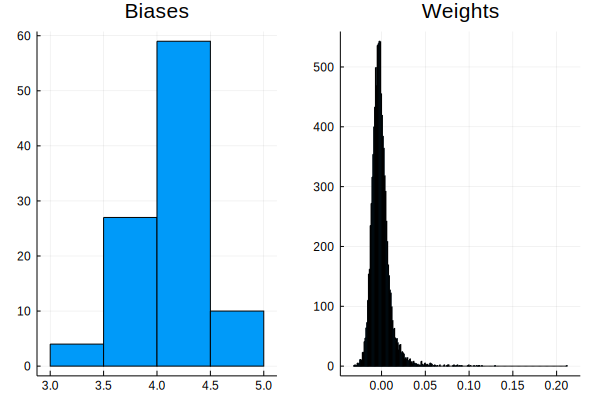

In [300]:
plot(histogram(testModel[2][:], legend=false, title="Biases"),
  histogram(testModel[1][:], legend=false, title="Weights"))

Competative waiting times

rand 0.7382954545454546
trained 0.7300530303030304
indep 0.8866287878787878


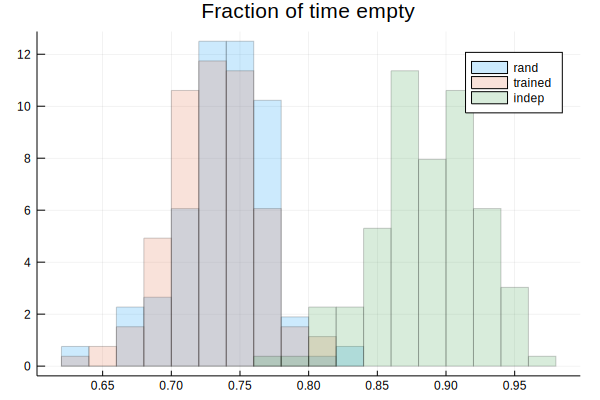

In [302]:
compareFor(compet(testLam), testM, testDists, 2; rand=randPol(testA,testLam), trained=testPol, indep=testA1Min) 

## Proportional policy

Instead of having drivers always turn onto the street that will give them the smallest expected waiting time, we can have them turn onto streets randomly in inverse proportion to expected waiting time.


$$
\label{propEq}
x = \lambda + (1 - \lambda)(1 + \Pi_x^T x)
$$



The policy matrix $\Pi$ is just $1/x$ multiplied columnwise on the adjacency matrix and normalized.

In [23]:
function a1Prop(A, lam)
  vals = fixedPoint(x-> lam .+ (1 .- lam) .* (1 .+ scorePolicy(1 ./ x, A)' * x), 1./ lam)
  (c(scorePolicy(1 ./ vals, A)), vals)
end

a1Prop (generic function with 1 method)

In [24]:
testA1Prop, testA1PropVals = a1Prop(testA, testLam);

Converged in 105 steps


This doesn't do any better than greedy

rand 0.8441145038167938
prop 0.8347150127226461
greedy 0.8444045801526717


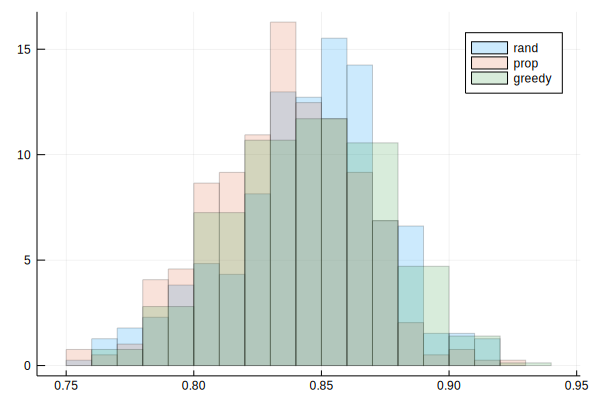

In [29]:
bench(competB, testLam, testM, testSt.dists, 5;
  rand=c(randPol(testA,testLam)), prop=testA1Prop, greedy=c(greedyPolProp(testA, testLam)))

Especially when competition is less.

rand 0.6816199999999999
prop 0.64542
greedy 0.58896


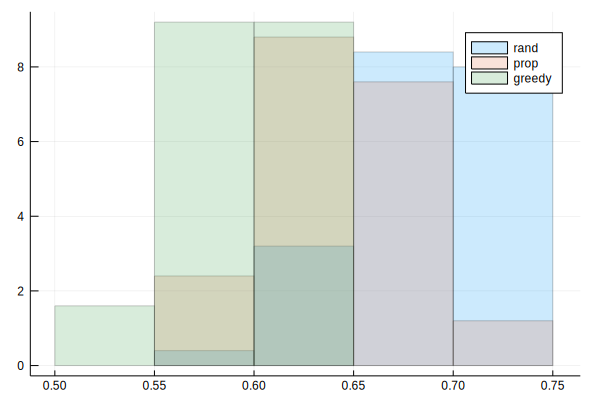

In [33]:
bench(competB, testLam, testM, testSt.dists, 1;
  rand=c(randPol(testA,testLam)), prop=testA1Prop, greedy=c(greedyPolProp(testA, testLam)))

Or nonexistent:

rand 0.6143593153652186
prop 0.5785048259400095
greedy 0.5130316171088611


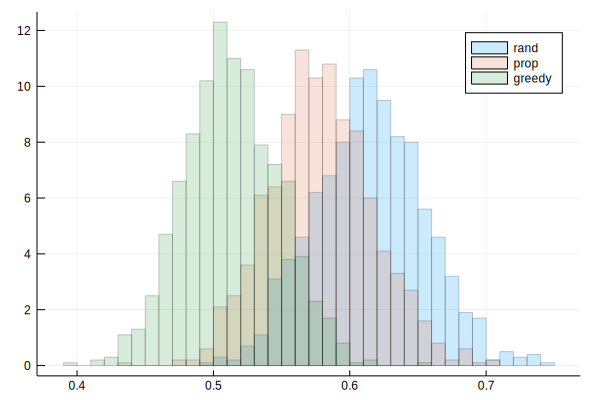

In [34]:
bench(indivB, testLam, testM, testSt.dists;
  rand=randPol(testA,testLam), prop=testA1Prop(true), greedy=greedyPolProp(testA, testLam))

rand 9.22
trained 11.022
greedy 20.718


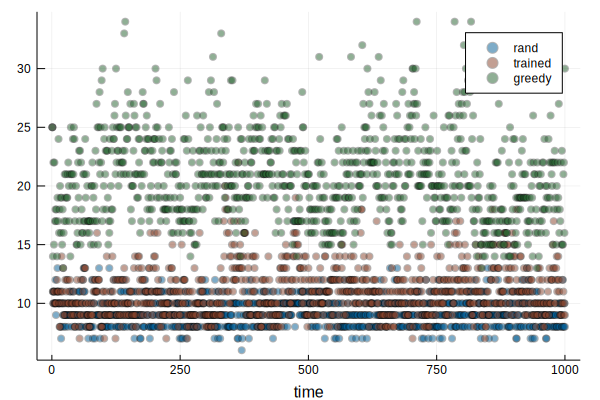

In [33]:
benchS(concentrations(competBDist), "time", testLam, testM, testSt.dists, 5; rand=c(randPol(testA,testLam)), trained=testA1Prop, greedy=c(greedyPolProp(testA, testLam)))

## Boltzman exploration

We can try to do something in between the two- favoring directions with shorter expected directions using Boltzmann exploration

In [35]:
boltz(x) = exp.(x .* 4)

boltz (generic function with 1 method)

In [38]:
function a1Boltz(A, lam)
  vals = fixedPoint(x-> lam .+ (1 .- lam) .* (1 .+ scorePolicy(boltz(1 ./ x), A)' * x), 1./ lam)
  (c(scorePolicy(boltz(1 ./ vals), A)), vals)
end

a1Boltz (generic function with 1 method)

In [39]:
testA1Boltz, testA1BoltzVals = a1Boltz(testA, testLam);

Converged in 149 steps


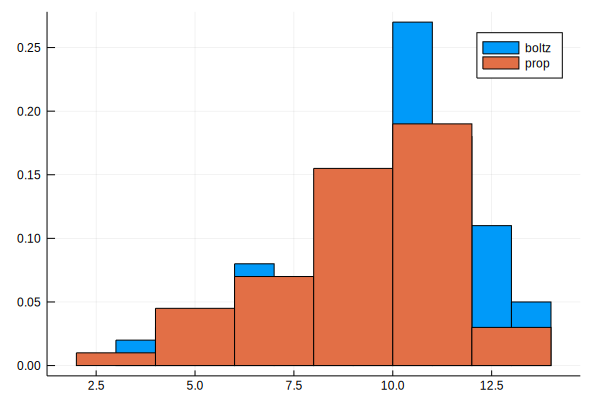

In [40]:
histogram([testA1BoltzVals testA1PropVals], label=["boltz" "prop"], normed=true)

rand 0.7737385321100916
boltz 0.7597614678899082
greedy 0.7557706422018349


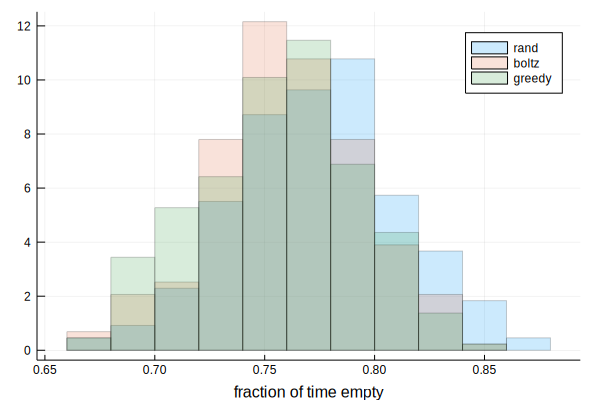

In [44]:
bench(competB, testLam, testM, testSt.dists, 3; rand=c(randPol(testA,testLam)), boltz=testA1Boltz, greedy=c(greedyPolProp(testA, testLam)))

But this doesn't seem to work very well either. 

## Repel policy

How does this compare to the 'repel' strategy: always go where there are the least taxis?

In [ ]:
# ah, we need to look one step ahead. Smartness is overrated. 

rand 0.828941475826972
greedy 0.8348447837150126
smartGreedy 0.8665979643765904


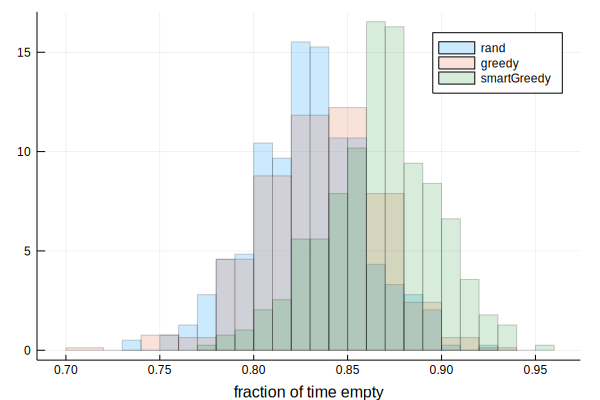

In [57]:
bench(competB, testLam, testM, testSt.dists, 5; rand=c(randPol(testA,testLam)), greedy=c(greedyPolProp(testA, testLam)),
smartGreedy=greedyF(testA, testLam))

### Debugging

In [35]:
rho0 = zeros(Int,testRoads)
rho0[1] = 1
rho0[2] = 1
rho0[11] = 1

1

In [55]:
replay(testG, testX, testY, testM, testLam, testSt.dists, greedyF(testA, testLam), rho0)

Reel.Frames{MIME{Symbol("text/html")}}("/tmp/tmpVYcEZ0", 0x000000000000000a, 1.0, nothing)

## Multi agent ideas

The single agent case can be parametrized by the density of other taxis at each node, $\rho$:

$$x_\rho = \frac{\lambda}{\rho + 1} + (1 - \frac{\lambda}{\rho + 1})(A \circ x_{\rho'}) $$

The problem is predicting what $\rho'$ is. What is the concentration of people before our next move?

We can do this with simulation. Go through every single person, sample a move according to the current estimates, and continue. 

Of course, this might not converge. And it only minimizes individual expected waiting time, not global time

It gives the expected time until a taxi added at node $i$ finds a passenger. 

We really want the average (over all taxis) time it will take to get the next passenger if we add a taxi at node $i$. 

Gah- this is really making the model free case look good. 

##  One smart, others greedy

In [ ]:
# We don't actually need this to be greedy. Just iterate it. 

In [90]:
# The iteration is a general case of the above. Do IT

In [ ]:
# Gah, thing about this.

$$x_\rho= \frac{\lambda}{\rho + 1} + \left(1 - \frac{\lambda}{\rho + 1}\right)
\left(A \circ \Pi_g (\max(0, \rho - (1-\frac{\lambda}{\rho))) \right) $$

rand 0.8660579999999999
trained 0.9587699999999997
greedy 0.9336579999999998


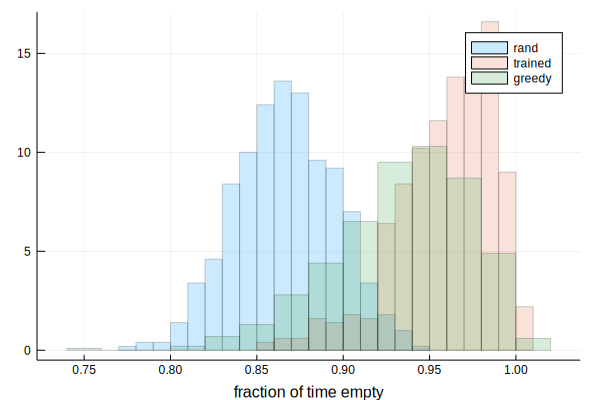

In [59]:
bench(withNTaxis(500,competB), fst, :hist, testNet, TaxiEmptyFrac;
  rand=c(randPol(testNet)), trained=solo(c(testA1Min), c(randPol(testNet)))